In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import pystan
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('/Users/ash/Downloads/clean.csv')

def clean_day_year(obj): 
    return int(obj)

def clean_month(obj):
    month = str(obj).lower()
    if month == 'jan': 
        month = '01'
    elif month == 'feb': 
        month = '02'
    elif month == 'mar': 
        month = '03'
    elif month == 'apr': 
        month = '04'
    elif month == 'may': 
        month = '05'
    elif month == 'jun': 
        month = '06'
    elif month == 'jul': 
        month = '07'
    elif month == 'aug': 
        month = '08'
    elif month == 'sep': 
        month = '09'
    elif month == 'oct': 
        month = '10'
    elif month == 'nov': 
        month = '11'
    elif month == 'dec': 
        month = '12'
    return month

def clean_fat(obj): 
    fat = str(obj)
    if fat.find('+') == -1:
        return int(fat)
    elif fat.find('+') != "+":
        total = int(fat[0:fat.find('+')]) + int(fat[fat.find('+')+2:])
        return int(total)

data = data.dropna()
data['day'] = data['day'].apply(clean_day_year)
data['year'] = data['year'].apply(clean_day_year)
data['month'] = data['month'].apply(clean_month)
data['fat.'] = data['fat.'].apply(clean_fat)

In [3]:
data['date'] = pd.to_datetime(data[['day', 'month', 'year']])

In [31]:
data.head()

,day,month,year,type,operator,fat.,cat,Aircraft Type,Aircraft Cat,date
0,1,04,1931,Ford 5-AT-C Tri-Motor,Panagra,0,A1,Military_research,Military,1931-04-01
1,1,04,1937,Ford 5-AT-C Tri-Motor,Star Air Service,0,A1,Military_research,Military,1937-04-01
2,1,04,1956,Martin 4-0-4,TWA,22,A1,Commercial_civil,Commercial,1956-04-01
5,1,08,1942,Junkers Ju-52/3mg4e,German AF,0,A1,Commercial_civil,Commercial,1942-08-01
6,1,12,1984,Boeing 720-027,NASA,0,O1,Commercial_civil,Commercial,1984-12-01


In [4]:
com = data.loc[data['Aircraft Cat'] == 'Commercial']
mil = data.loc[data['Aircraft Cat'] == 'Military']
print('Commercial Size:', com.shape)
print('Miliatary Size:', mil.shape)

Commercial Size: (6496, 10)
Miliatary Size: (11042, 10)


# Modeling Trends

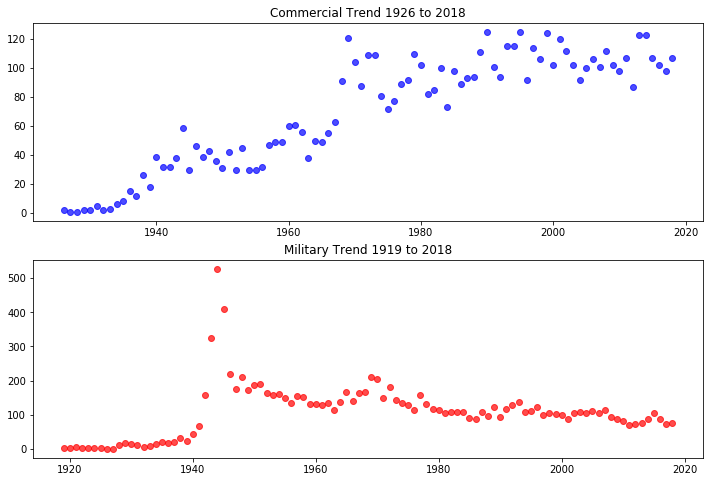

In [32]:
#general trend by
year_count_com = (com['year'].value_counts()).reset_index()
year_count_com = year_count_com.sort_values(by=['index'], kind='mergesort')
year_count_com = year_count_com.reset_index(drop=True)

year_count_mil = mil['year'].value_counts().reset_index()
year_count_mil = year_count_mil.sort_values(by=['index'], kind='mergesort')
year_count_mil = year_count_mil.reset_index(drop=True)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.scatter(range(year_count_com['index'].iloc[0], year_count_com['index'].iloc[-1]+1),\
            year_count_com['year'], color='b', alpha=0.7)
plt.title('Commercial Trend {} to {}'.format(year_count_com['index'].iloc[0],year_count_com['index'].iloc[-1]))
plt.subplot(2,1,2)
plt.scatter(range(year_count_mil['index'].iloc[0], year_count_mil['index'].iloc[-1]+1),\
            year_count_mil['year'], color='r', alpha=0.7)
plt.title('Military Trend {} to {}'.format(year_count_mil['index'].iloc[0],year_count_mil['index'].iloc[-1]))
plt.show()

year_count_com['abs_year'] = year_count_com['index']
year_count_mil['abs_year'] = year_count_mil['index']
def visualize_posterior(samples, names): 
    for _ in names:
        plt.figure(figsize=(12,4))
        plt.hist(samples[_])
        plt.title('Posterior samples of '+_)
    plt.show()

**_LINEAR**: Commercial

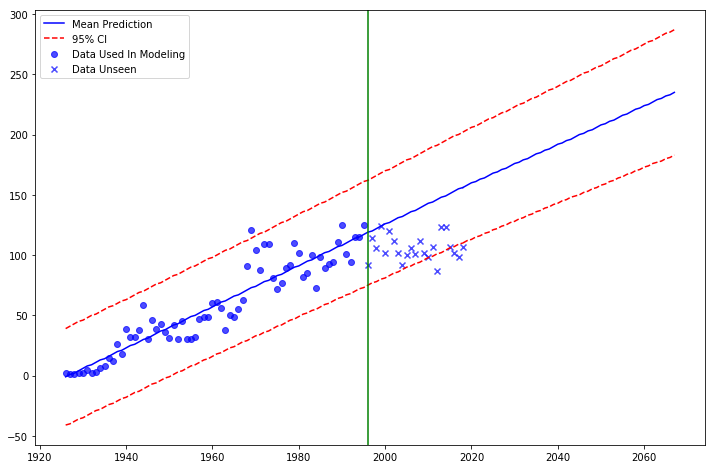

In [34]:
scaler = MinMaxScaler()
N = 70

year_count_com['index'] = scaler.fit_transform(np.array(year_count_com['index']).reshape(-1,1))
reg = BayesianRidge()
reg.fit(np.array(year_count_com[['index']].iloc[:N,:]), year_count_com['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
y_m, y_std = reg.predict(np.array(year_count_com[['index']]), return_std=True)
plt.plot(x, np.round(y_m), color='b', label='Mean Prediction')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.linspace(1,1.5,50)
f_y_m, f_y_std = reg.predict(f_x.reshape(-1,1), return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

In [35]:
model_trend = """

data {
//Data and its length
    int<lower=1> length; 
    real<lower=0> data_[length];
//Number of generated values
    int<lower=0> n_gen;
}

parameters {
    //Linear trend model, with 2 coefficients
    real coef_1;
    real coef_2;
    real<lower=0> noise; 
}

model {
    #Each coefficient is drawn from a broad Cauchy
    coef_1 ~ cauchy(0,1);
    coef_2 ~ cauchy(0,1);
    noise ~ cauchy(0,1);
    for(i in 1:length) {
        data_[i] ~ normal(coef_1*i + coef_2, noise); 
    }
}

generated quantities {
    real data_gen[n_gen];
    for(i in 1:n_gen) {
        data_gen[i] = normal_rng(coef_1*(i+length) + coef_2, noise);
    }
}
"""
stan_model_trend = pystan.StanModel(model_code=model_trend)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9fc9535f85555f21a1966eb38a9c58bd NOW.
/Users/ash/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmp00bvlanu/stanfit4anon_model_9fc9535f85555f21a1966eb38a9c58bd_5483545628158196184.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [36]:
stan_data = {
    'length': year_count_com['year'][:N].shape[0],
    'data_': np.array(year_count_com['year'][:N]),
    'n_gen': year_count_com['year'][N:].shape[0] + 50
}
results = stan_model_trend.sampling(data=stan_data)
samples = results.extract()

In [37]:
paras =['coef_1', 'coef_2', 'noise']
print(results.stansummary(pars=paras))

Inference for Stan model: anon_model_9fc9535f85555f21a1966eb38a9c58bd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
coef_1   1.67  1.4e-3   0.06   1.57   1.63   1.66    1.7   1.78   1467    1.0
coef_2  -0.66    0.05   1.81  -5.22  -1.35  -0.35   0.35   2.23   1217    1.0
noise    14.0    0.02   1.22   11.9  13.14  13.91  14.77   16.6   2749    1.0

Samples were drawn using NUTS at Fri Dec 21 08:07:56 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


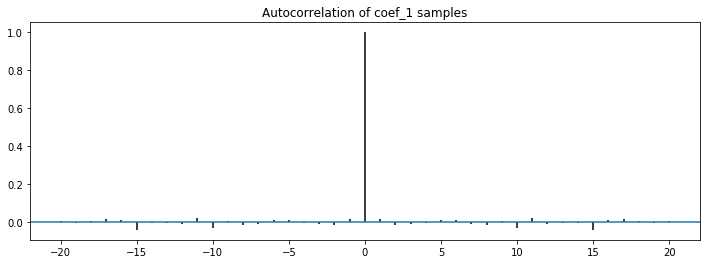

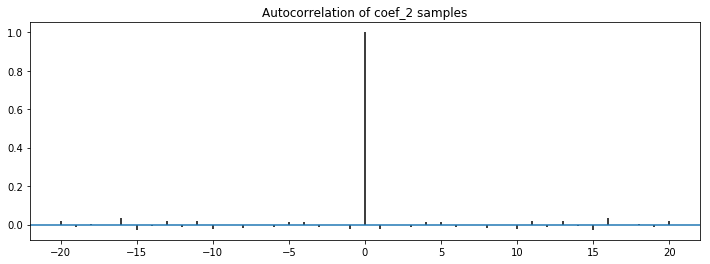

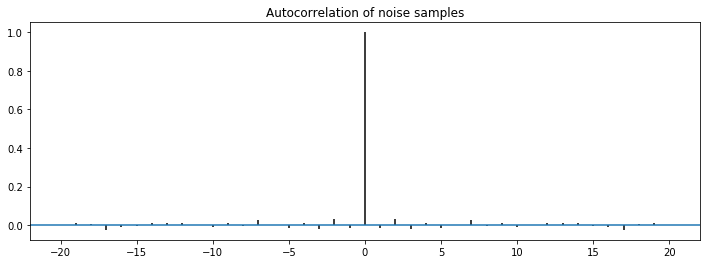

In [38]:
#From CS146 - 14.1 Pre-class, Professor Carl Scheffler
def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in paras:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

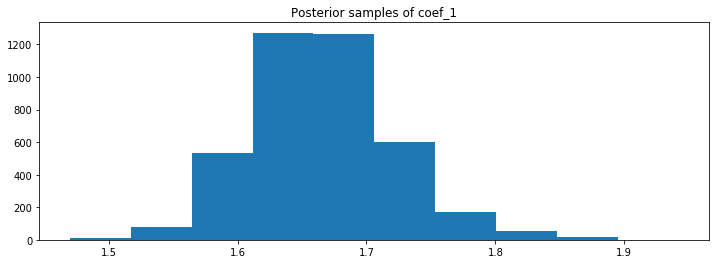

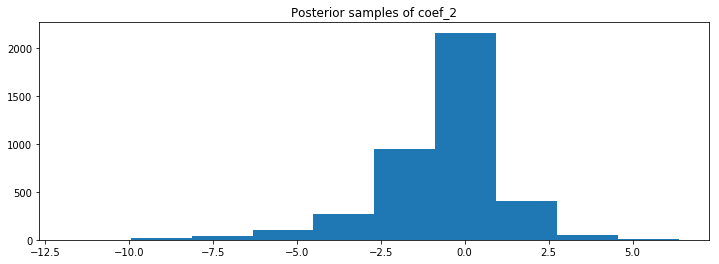

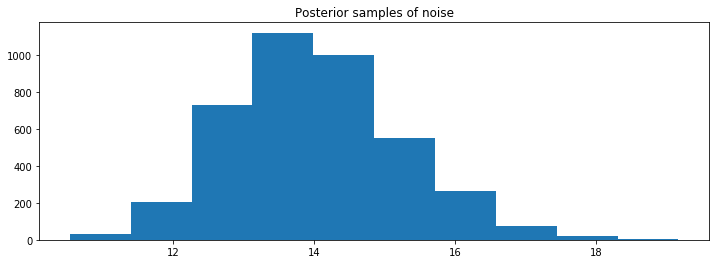

In [39]:
visualize_posterior(samples, paras)

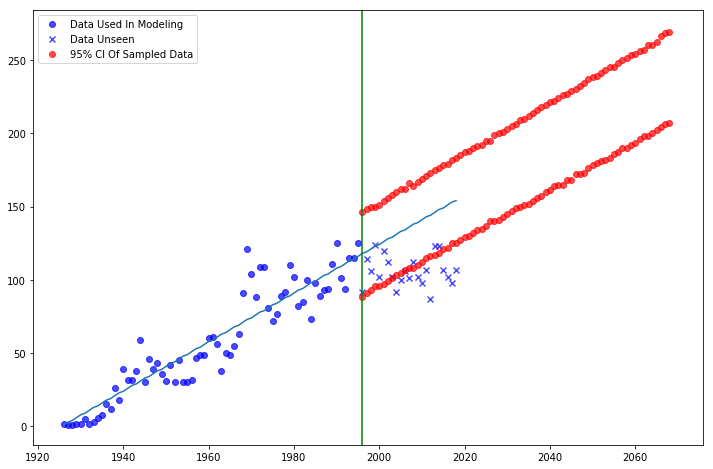

In [40]:
future = samples['data_gen']
f_interval = np.percentile(future, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
x_ = range(1, year_count_com['index'].shape[0]+1)
y = np.round([x_[i]*np.mean(samples['coef_1'])+np.mean(samples['coef_2']) for i in range(len(x))])
plt.plot(year_count_com['abs_year'], y)
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[0,:]), color='r', alpha=0.7,\
            label='95% CI Of Sampled Data')
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[1,:]), color='r', alpha=0.7)
plt.axvline(x[N], color='g')
plt.legend()
plt.show()

**_LINEAR**: Military

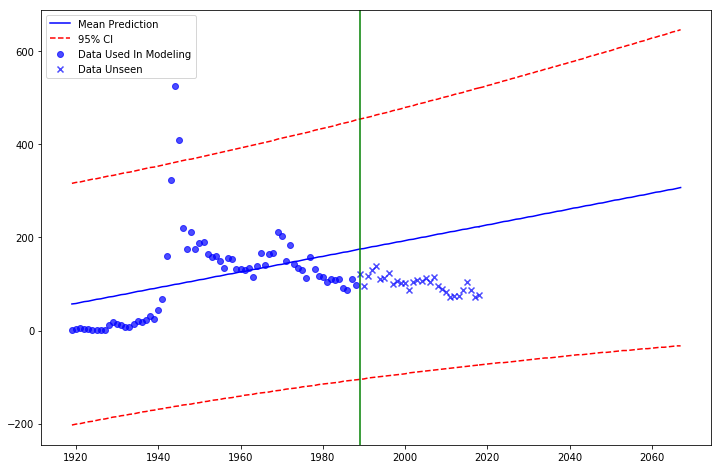

In [48]:
scaler = MinMaxScaler()
N = 70

year_count_mil['index'] = scaler.fit_transform(np.array(year_count_mil['index']).reshape(-1,1))
reg = BayesianRidge()
reg.fit(np.array(year_count_mil[['index']].iloc[:N,:]), year_count_mil['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_mil['abs_year']
plt.scatter(x[:N], year_count_mil['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_mil['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
y_m, y_std = reg.predict(np.array(year_count_mil[['index']]), return_std=True)
plt.plot(x, np.round(y_m), color='b', label='Mean Prediction')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.linspace(1,1.5,50)
f_y_m, f_y_std = reg.predict(f_x.reshape(-1,1), return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

In [42]:
stan_data = {
    'length': year_count_mil['year'][:N].shape[0],
    'data_': np.array(year_count_mil['year'][:N]),
    'n_gen': year_count_mil['year'][N:].shape[0] + 50
}
results = stan_model_trend.sampling(data=stan_data)
samples = results.extract()

In [43]:
paras =['coef_1', 'coef_2', 'noise']
print(results.stansummary(pars=paras))

Inference for Stan model: anon_model_9fc9535f85555f21a1966eb38a9c58bd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
coef_1   2.65    0.03   0.47   1.39   2.48   2.73   2.97   3.33    317   1.03
coef_2    8.4    1.12  17.92  -3.33  -0.31   0.78   5.75  63.38    254   1.03
noise   92.42    0.37   8.37  77.93  86.54  91.84  97.76 109.83    505    1.0

Samples were drawn using NUTS at Fri Dec 21 08:08:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


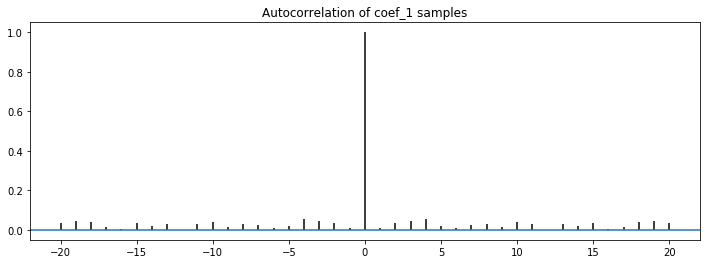

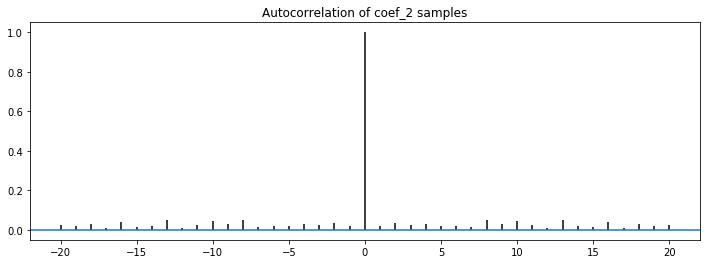

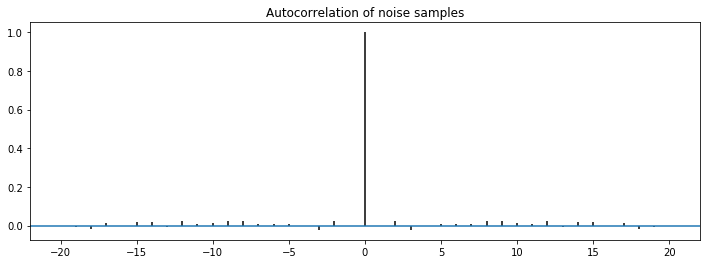

In [44]:
for param in paras:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

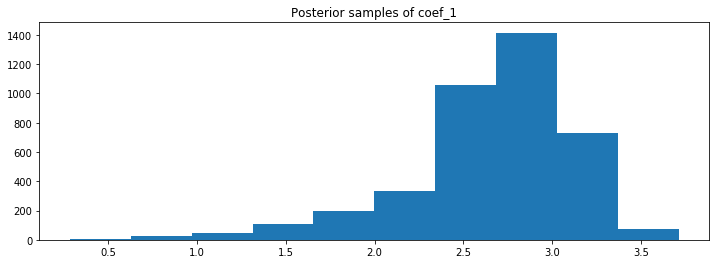

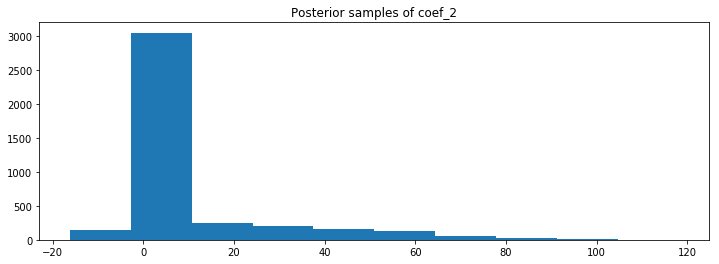

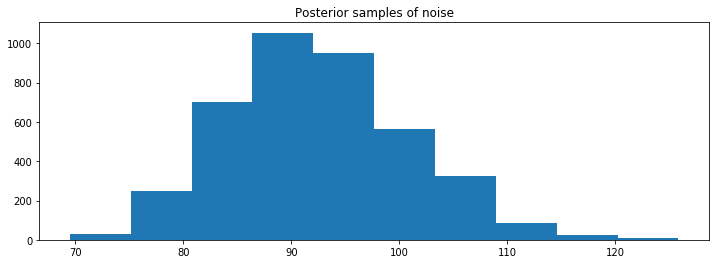

In [45]:
visualize_posterior(samples, paras)

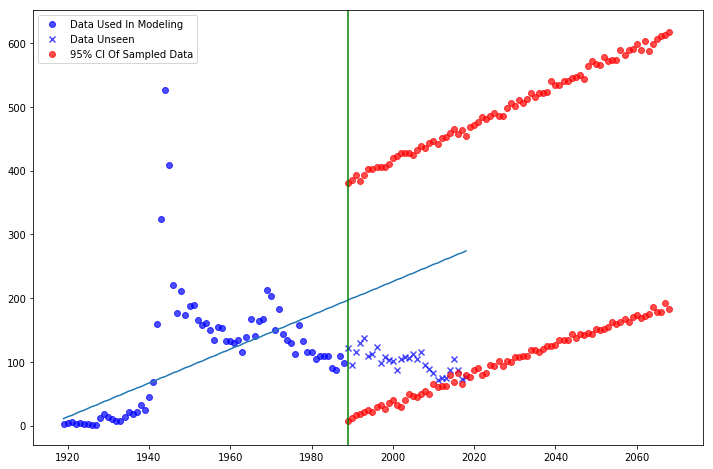

In [46]:
future = samples['data_gen']
f_interval = np.percentile(future, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(12,8))
x = year_count_mil['abs_year']
plt.scatter(x[:N], year_count_mil['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_mil['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
x_ = range(1, year_count_mil['index'].shape[0]+1)
y = np.round([x_[i]*np.mean(samples['coef_1'])+np.mean(samples['coef_2']) for i in range(len(x))])
plt.plot(year_count_mil['abs_year'], y)
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[0,:]), color='r', alpha=0.7,\
            label='95% CI Of Sampled Data')
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[1,:]), color='r', alpha=0.7)
plt.axvline(x[N], color='g')
plt.legend()
plt.show()

**_QUADRATIC**: Commericial

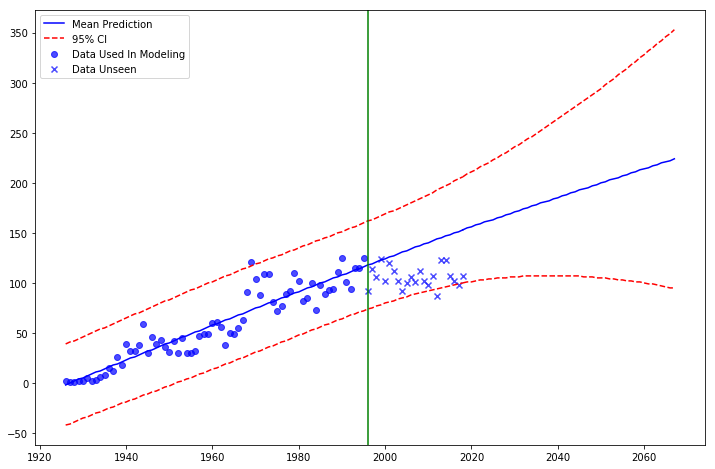

In [49]:
scaler = MinMaxScaler()
N = 70

year_count_com['index'] = scaler.fit_transform(np.array(year_count_com['index']).reshape(-1,1))
year_count_com['index^2'] = year_count_com['index']**2
reg = BayesianRidge()
reg.fit(np.array(year_count_com[['index', 'index^2']].iloc[:N,:]), year_count_com['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
y_m, y_std = reg.predict(np.array(year_count_com[['index', 'index^2']]), return_std=True)
plt.plot(x, np.round(y_m), label='Mean Prediction', color='b')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.expand_dims(np.linspace(1,1.5,50), axis=1)
f_x = np.concatenate((f_x, f_x**2), axis=1)
f_y_m, f_y_std = reg.predict(f_x, return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

In [52]:
model_trend = """

data {
//Data and its length
    int<lower=1> length; 
    real<lower=0> data_[length];
//Number of generated values
    int<lower=0> n_gen;
}

parameters {
    //Quadratic trend model, with 3 coefficients
    real coef_1;
    real coef_2;
    real coef_3;
    real<lower=0> noise; 
}

model {
    #Each coefficient is drawn from a broad Cauchy
    coef_1 ~ cauchy(0,1);
    coef_2 ~ cauchy(0,1);
    coef_3 ~ cauchy(0,1);
    for(i in 1:length) {
        data_[i] ~ normal(coef_1*i*i + coef_2*i + coef_3, noise); 
    }
}

generated quantities {
    real data_gen[n_gen];
    for(i in 1:n_gen) {
        data_gen[i] = normal_rng(coef_1*(i+length)*(i+length) + coef_2*(i+length) + coef_3, noise);
    }
}
"""
stan_model_trend = pystan.StanModel(model_code=model_trend)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bcc78e8e9558ca95b7d69a709dfaec3e NOW.
/Users/ash/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmp4om8lxao/stanfit4anon_model_bcc78e8e9558ca95b7d69a709dfaec3e_6929362435638680677.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [53]:
stan_data = {
    'length': year_count_com['year'][:N].shape[0],
    'data_': np.array(year_count_com['year'][:N]),
    'n_gen': year_count_com['year'][N:].shape[0]+50
}
results = stan_model_trend.sampling(data=stan_data)
samples = results.extract()

In [54]:
paras =['coef_1', 'coef_2', 'coef_3', 'noise']
print(results.stansummary(pars=paras))

Inference for Stan model: anon_model_bcc78e8e9558ca95b7d69a709dfaec3e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
coef_1 8.3e-4  9.0e-5 3.3e-3-6.0e-3-1.3e-3 8.7e-4 3.0e-3 7.4e-3   1360    1.0
coef_2   1.62  6.0e-3    0.2   1.23   1.49   1.62   1.74   2.05   1170    1.0
coef_3  -0.63    0.07   2.17  -6.52  -1.26  -0.27   0.41   3.22   1054    1.0
noise   14.09    0.03   1.21  11.93  13.25  14.03  14.86  16.73   2006    1.0

Samples were drawn using NUTS at Fri Dec 21 08:16:53 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


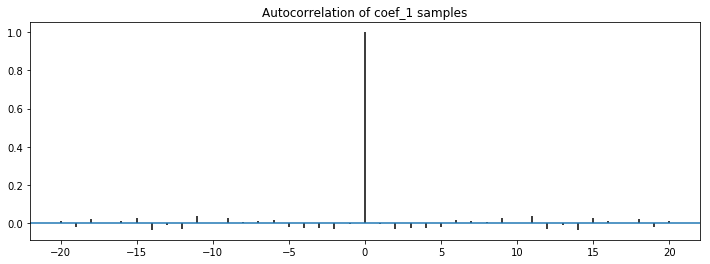

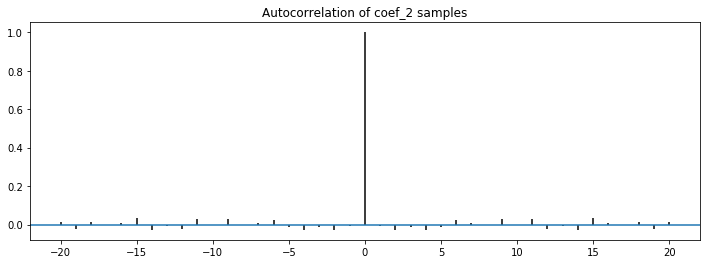

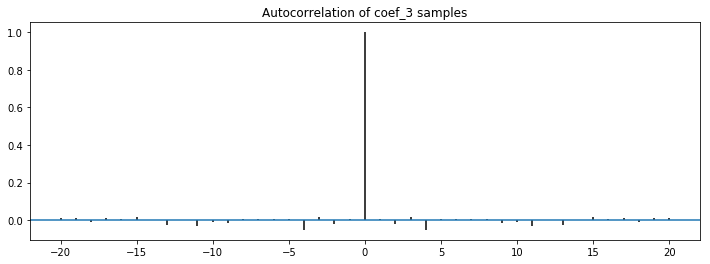

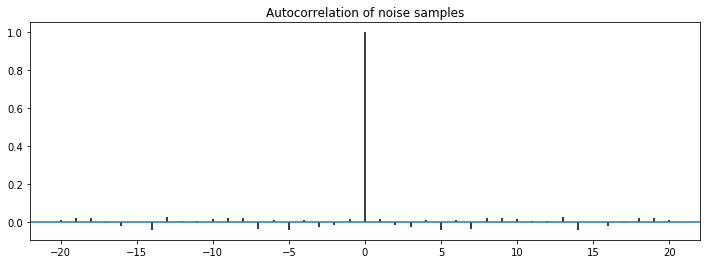

In [55]:
for param in paras:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

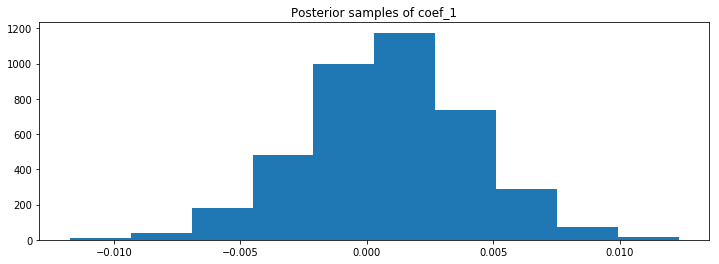

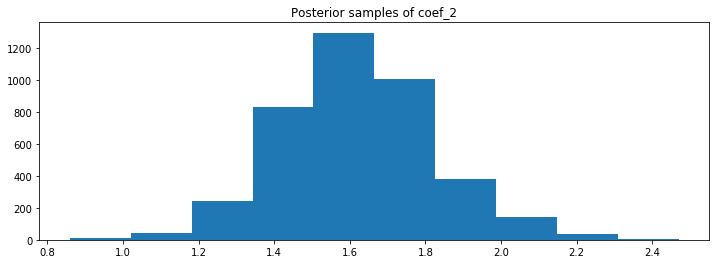

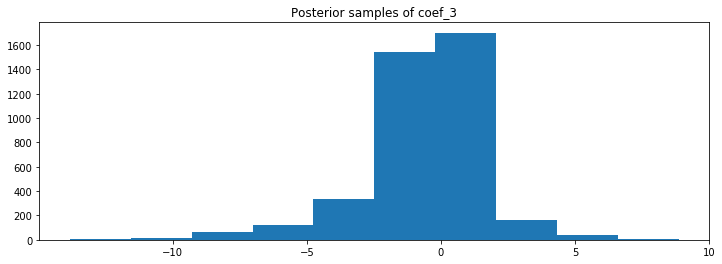

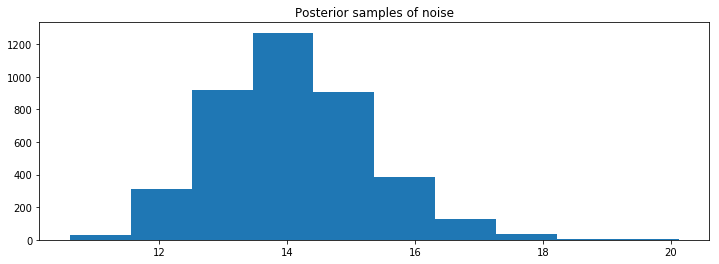

In [56]:
visualize_posterior(samples, paras)

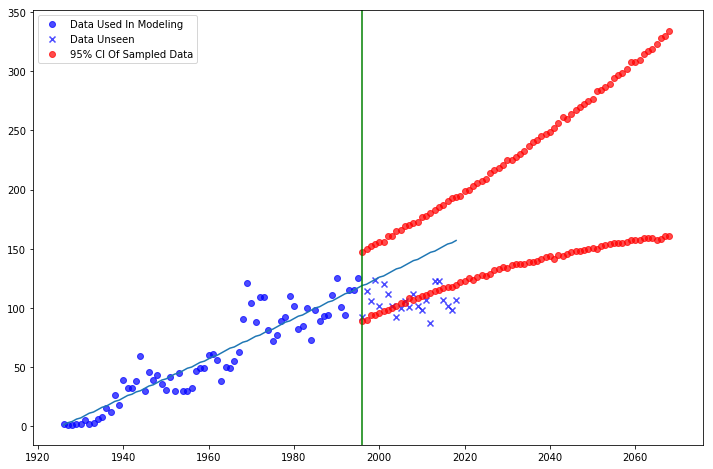

In [57]:
future = samples['data_gen']
f_interval = np.percentile(future, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
x_ = range(1, year_count_com['index'].shape[0]+1)
y = np.round([x_[i]**2*np.mean(samples['coef_1'])+x_[i]*np.mean(samples['coef_2']) + np.mean(samples['coef_3'])\
              for i in range(len(x))])
plt.plot(year_count_com['abs_year'], y)
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[0,:]), color='r', alpha=0.7,\
            label='95% CI Of Sampled Data')
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[1,:]), color='r', alpha=0.7)
plt.axvline(x[N], color='g')
plt.legend()
plt.show()

**_Quadratic**: Military

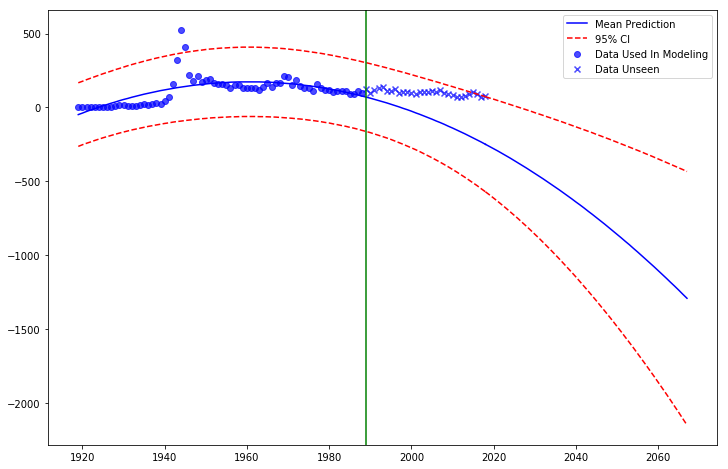

In [60]:
scaler = MinMaxScaler()
N = 70

year_count_mil['index'] = scaler.fit_transform(np.array(year_count_mil['index']).reshape(-1,1))
year_count_mil['index^2'] = year_count_mil['index']**2
reg = BayesianRidge()
reg.fit(np.array(year_count_mil[['index', 'index^2']].iloc[:N,:]), year_count_mil['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_mil['abs_year']
plt.scatter(x[:N], year_count_mil['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_mil['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
y_m, y_std = reg.predict(np.array(year_count_mil[['index', 'index^2']]), return_std=True)
plt.plot(x, np.round(y_m), label='Mean Prediction', color='b')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.expand_dims(np.linspace(1,1.5,50), axis=1)
f_x = np.concatenate((f_x, f_x**2), axis=1)
f_y_m, f_y_std = reg.predict(f_x, return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

In [61]:
stan_data = {
    'length': year_count_mil['year'][:N].shape[0],
    'data_': np.array(year_count_mil['year'][:N]),
    'n_gen': year_count_mil['year'][N:].shape[0]+50
}
results = stan_model_trend.sampling(data=stan_data)
samples = results.extract()

In [62]:
paras =['coef_1', 'coef_2', 'coef_3', 'noise']
print(results.stansummary(pars=paras))

Inference for Stan model: anon_model_bcc78e8e9558ca95b7d69a709dfaec3e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
coef_1  -0.09  5.6e-4   0.02  -0.13   -0.1  -0.09  -0.08  -0.06   1026    1.0
coef_2   7.71    0.04   1.08    5.8   7.01   7.66   8.32  10.03    840    1.0
coef_3   -3.0    0.47  10.49 -38.77  -1.93   -0.3   0.56   5.28    503   1.01
noise   76.96    0.17   6.54  65.37  72.41  76.49  81.16  91.04   1499    1.0

Samples were drawn using NUTS at Fri Dec 21 08:18:38 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


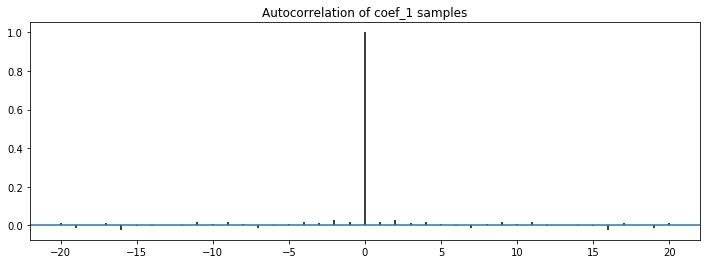

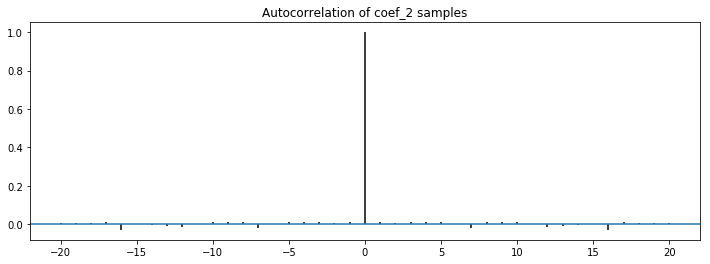

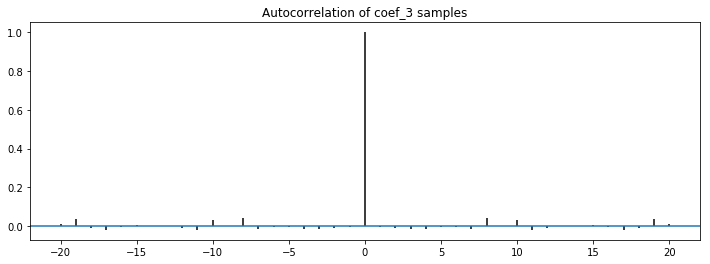

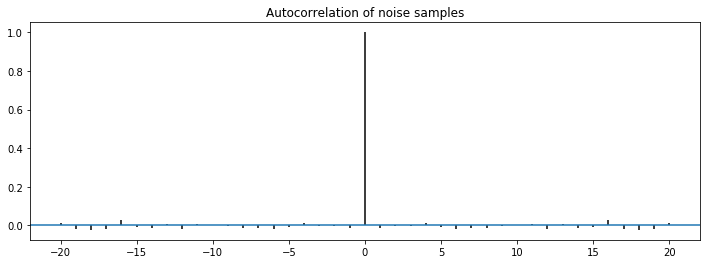

In [63]:
#From CS146 - 14.1 Pre-class, Professor Carl Scheffler
def plot_acf(x):
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))


for param in paras:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

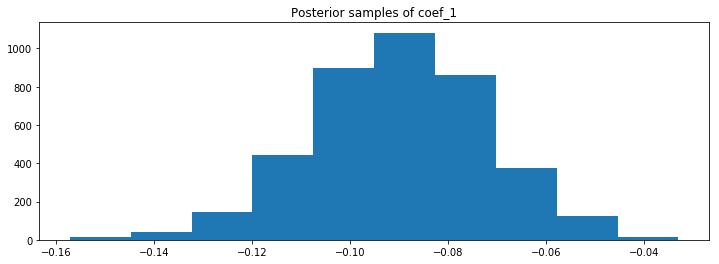

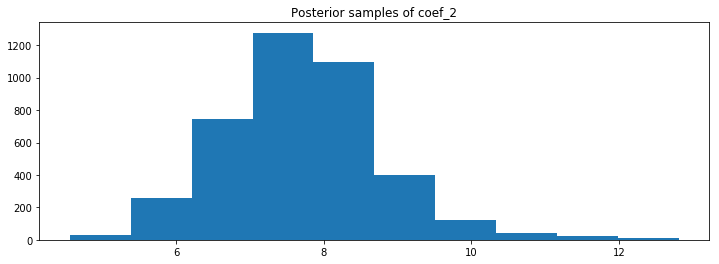

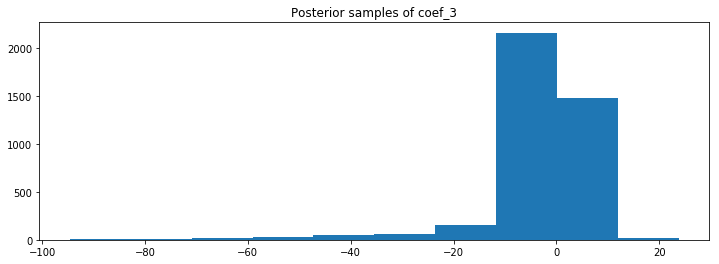

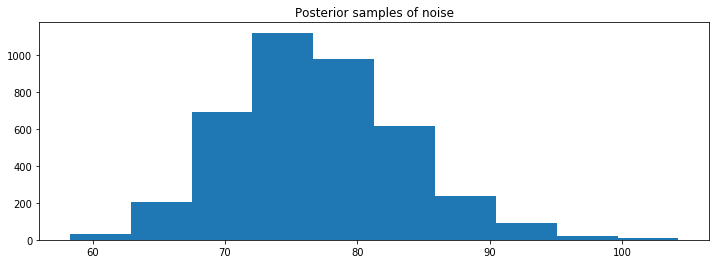

In [64]:
visualize_posterior(samples, paras)

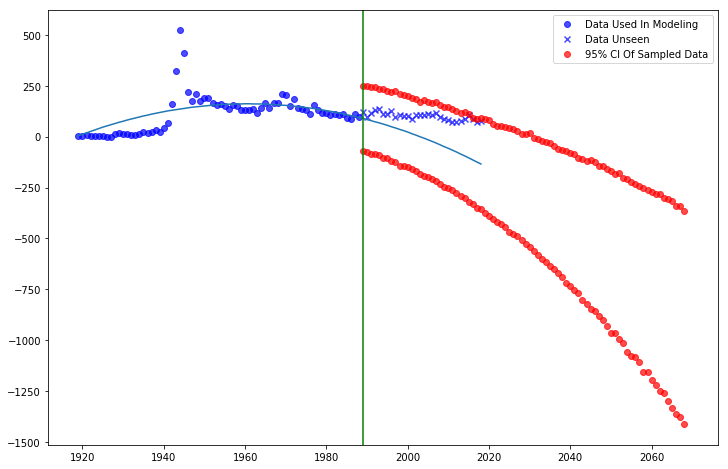

In [65]:
future = samples['data_gen']
f_interval = np.percentile(future, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(12,8))
x = year_count_mil['abs_year']
plt.scatter(x[:N], year_count_mil['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_mil['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
x_ = range(1, year_count_mil['index'].shape[0]+1)
y = np.round([x_[i]**2*np.mean(samples['coef_1'])+x_[i]*np.mean(samples['coef_2'])+np.mean(samples['coef_3'])\
              for i in range(len(x))])
plt.plot(year_count_mil['abs_year'], y)
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[0,:]), color='r', alpha=0.7,\
            label='95% CI Of Sampled Data')
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[1,:]), color='r', alpha=0.7)
plt.axvline(x[N], color='g')
plt.legend()
plt.show()

**_Radial Basis Function**: Commercial & Military: BayesRidge

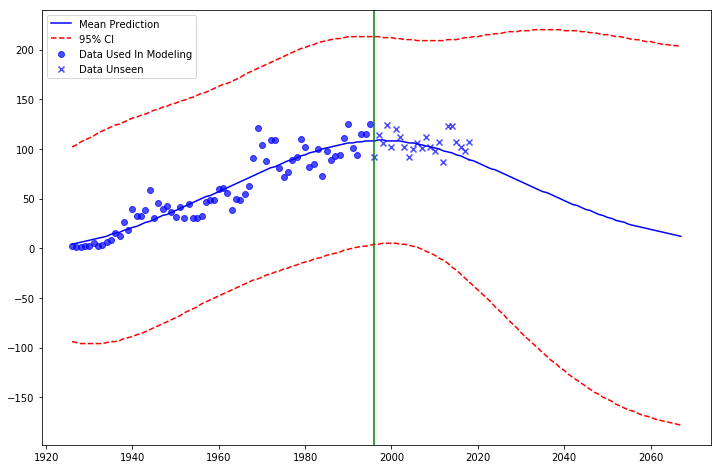

In [66]:
scaler = MinMaxScaler()
N = 70

#Using sklearn rbf kernel
from sklearn.metrics.pairwise import rbf_kernel

#100 pivot points
kernel = np.linspace(0,2,100).reshape(-1,1)
#Rescaling the year to the range 0 to 1, a standard procedure before fitting
year_count_com['index'] = scaler.fit_transform(np.array(year_count_com['index']).reshape(-1,1))

X_train = rbf_kernel(np.array(year_count_com['index'][:N]).reshape(-1,1), kernel, gamma=10)

#Using Bayesian model and plotting the results
reg = BayesianRidge()
reg.fit(X_train, year_count_com['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')

X_test = rbf_kernel(np.array(year_count_com['index']).reshape(-1,1),\
                    kernel, gamma=10)
y_m, y_std = reg.predict(X_test, return_std=True)
plt.plot(x, np.round(y_m), color='b', label='Mean Prediction')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.linspace(1,1.5,50).reshape(-1,1)
K_f_x = rbf_kernel(f_x, kernel, gamma=10)
f_y_m, f_y_std = reg.predict(K_f_x, return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

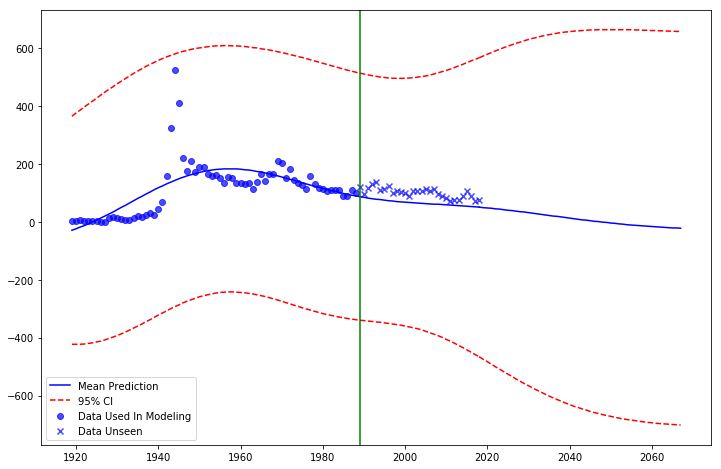

In [67]:
scaler = MinMaxScaler()
N = 70

from sklearn.metrics.pairwise import rbf_kernel

kernel = np.linspace(0,2,100).reshape(-1,1)
year_count_mil['index'] = scaler.fit_transform(np.array(year_count_mil['index']).reshape(-1,1))

X_train = rbf_kernel(np.array(year_count_mil['index'][:N]).reshape(-1,1), kernel, gamma=10)

reg = BayesianRidge()
reg.fit(X_train, year_count_mil['year'].iloc[:N])
plt.figure(figsize=(12,8))
x = year_count_mil['abs_year']
plt.scatter(x[:N], year_count_mil['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_mil['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')

X_test = rbf_kernel(np.array(year_count_mil['index']).reshape(-1,1),\
                    kernel, gamma=10)
y_m, y_std = reg.predict(X_test, return_std=True)
plt.plot(x, np.round(y_m), color='b', label='Mean Prediction')
plt.plot(x, np.round(y_m+2.96*y_std), color='r', linestyle='--', label='95% CI')
plt.plot(x, np.round(y_m-2.96*y_std), color='r', linestyle='--')

f_x = np.linspace(1,1.5,50).reshape(-1,1)
K_f_x = rbf_kernel(f_x, kernel, gamma=10)
f_y_m, f_y_std = reg.predict(K_f_x, return_std=True)
f_x = range(2018, 2018+50)
plt.plot(f_x, np.round(f_y_m), color='b')
plt.plot(f_x, np.round(f_y_m+2.96*f_y_std), color='r', linestyle='--')
plt.plot(f_x, np.round(f_y_m-2.96*f_y_std), color='r', linestyle='--')

plt.axvline(x[N], color='g')
plt.legend()
plt.show()

**_Radial Basis Function**: Commercial & Military: Stan

In [68]:
model_trend_main = """

data {
//Data and its length
    int<lower=1> length; 
    real<lower=0> data_[length];
//Number of radial basis points or number of coefficients
    int<lower=1> c;
//Kernelized value of the training data
    vector[c] rbf_train[length]; 
//Number of generated values
    int<lower=0> n_gen;
//Kernelized value of the generated data
    vector[c] rbf_gen[n_gen]; 
}

parameters {
//RBF model, with c basis points
    row_vector[c] coef_;
//Intercept
    real intercept;
//Gaussian noise
    real<lower=0> noise; 
}

model {
//Each coefficient is drawn from a broad Cauchy
    for(j in 1:c) {
        coef_[j] ~ cauchy(0,1);
    }
    for(i in 1:length) {
        data_[i] ~ normal((coef_*rbf_train[i]) + intercept, noise); 
    }
}

generated quantities {
    real data_gen[n_gen];
    for(i in 1:n_gen) {
        data_gen[i] = normal_rng((coef_*rbf_gen[i]) + intercept, noise);
    }
}
"""
trend_model = pystan.StanModel(model_code=model_trend_main)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8eaaf89611cb1dd182290154aaa1383d NOW.
/Users/ash/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmpj8a_h85s/stanfit4anon_model_8eaaf89611cb1dd182290154aaa1383d_5380216097097684606.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [69]:
kernel = np.linspace(0,2,100).reshape(-1,1)
X_train = rbf_kernel(np.array(year_count_com['index'][:N]).reshape(-1,1), kernel, gamma=10)
X_gen = rbf_kernel(np.array(year_count_com['index'].iloc[N:]).reshape(-1,1), kernel, gamma=10)
f_X = np.linspace(1,1.5,50).reshape(-1,1)
K_f_X = rbf_kernel(f_X, kernel, gamma=10)
X_gen = np.concatenate((X_gen, K_f_X), axis=0)

stan_data = {
    'length': year_count_com['year'][:N].shape[0],
    'data_': np.array(year_count_com['year'][:N]),
    'c': 100,
    'rbf_train': X_train,
    'n_gen': year_count_com['year'][N:].shape[0] + 50, 
    'rbf_gen': X_gen
}
results = trend_model.sampling(data=stan_data)
samples = results.extract()

In [70]:
paras = ['coef_', 'intercept', 'noise']
print(results.stansummary(pars=paras))

Inference for Stan model: anon_model_8eaaf89611cb1dd182290154aaa1383d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
coef_[1]    -5.44    0.85  17.45 -68.84  -2.05  -0.35   0.62   6.27    419    1.0
coef_[2]    -4.28    1.05   15.4 -62.73  -1.76  -0.24   0.66    6.5    214   1.01
coef_[3]    -3.41    0.84  14.63 -57.42  -1.58  -0.23    0.7   6.97    305   1.01
coef_[4]    -0.82    0.45  10.59 -19.81   -1.2  -0.11   0.83   8.91    543    1.0
coef_[5]    -0.74    0.29   7.15 -12.49  -1.09  -0.08   0.88   6.59    617   1.01
coef_[6]    -0.76    0.26   7.35 -16.07  -1.04  -0.05   0.95   7.76    817   1.01
coef_[7]    -0.06    0.45   8.29 -15.18  -0.97  -0.03   0.96  10.91    336   1.01
coef_[8]     0.52    0.18   6.07  -9.37  -0.94   0.07   1.15  14.22   1168    1.0
coef_[9]     0.83    0.25   7.23   -9.9  -0.84   0.11   1.14  18.68    82

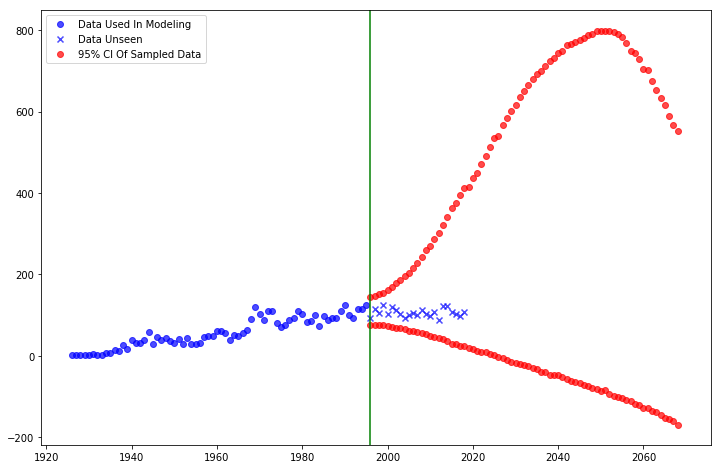

In [71]:
future = samples['data_gen']
f_interval = np.percentile(future, axis=0, q=[2.5, 97.5])
plt.figure(figsize=(12,8))
x = year_count_com['abs_year']
plt.scatter(x[:N], year_count_com['year'][:N], color='b', alpha=0.7, label='Data Used In Modeling')
plt.scatter(x[N:], year_count_com['year'][N:], color='b', marker='x', alpha=0.7, label='Data Unseen')
x_ = range(1, year_count_com['index'].shape[0]+1)
# y = np.round([x_[i]**2*np.mean(samples['coef_1'])+x_[i]*np.mean(samples['coef_2']) + np.mean(samples['coef_3'])\
#               for i in range(len(x))])
# plt.plot(year_count_com['abs_year'], y)
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[0,:]), color='r', alpha=0.7,\
            label='95% CI Of Sampled Data')
plt.scatter(x[N]+range(stan_data['n_gen']), np.round(f_interval[1,:]), color='r', alpha=0.7)
plt.axvline(x[N], color='g')
plt.legend()
plt.show()

# Modeling Risk: Commercial

In [5]:
risk_com = com[['year', 'type', 'operator', 'fat.', 'cat']].reset_index(drop=True)

In [6]:
def clean_cat_1(obj):
    obj = str(obj)
    return obj[0]

def clean_cat_2(obj):
    obj = str(obj)
    return obj[1]

risk_com['Accident Type'] = risk_com['cat']
risk_com['Loss Type'] = risk_com['cat']
risk_com = risk_com.drop(['cat'], axis=1)
risk_com['Accident Type'] = risk_com['Accident Type'].apply(clean_cat_1) 
risk_com['Loss Type'] = risk_com['Loss Type'].apply(clean_cat_2) 
risk_com = risk_com.sort_values(by=['year'], kind='mergesort').reset_index(drop=True)

In [ ]:
risk_com.head()

In [7]:
def Boeing_Airbus(data):
    df = pd.DataFrame()
    for _ in range(data.shape[0]):
        if ('Boeing' in data['type'].iloc[_]):
            data.iloc[_, 1] = data.iloc[_, 1][:10]
            if data.iloc[_, 1] == 'Boeing':
                pass
            else: 
                df = pd.concat((df, data.iloc[_,:]), axis=1, sort=False)
        elif ('Airbus' in data['type'].iloc[_]): 
            data.iloc[_, 1] = data.iloc[_, 1][:11]
            if data.iloc[_, 1] == 'Airbus':
                pass
            else:
                df = pd.concat((df, data.iloc[_,:]), axis=1, sort=False)
    return df.transpose().reset_index(drop=True)

def Top_Airline(data, top_airlines):
    df = pd.DataFrame()
    for _ in range(data.shape[0]): 
        if data['operator'].iloc[_] in top_airlines:
            df = pd.concat((df, data.iloc[_,:]), axis=1, sort=False)
    return df.transpose().reset_index(drop=True)

def how_many_passenger(data): 
    data['total'] = np.nan
    for _ in range(data.shape[0]): 
        if data['type'].iloc[_] == 'Boeing 727':
            data['total'].iloc[_] = 189
        elif data['type'].iloc[_] == 'Boeing 737':
            data['total'].iloc[_] = 143
        elif data['type'].iloc[_] == 'Boeing 707':
            data['total'].iloc[_] = 189
        elif data['type'].iloc[_] == 'Boeing 747':
            data['total'].iloc[_] = 660
        elif data['type'].iloc[_] == 'Boeing 720':
            data['total'].iloc[_] = 219
        elif data['type'].iloc[_] == 'Boeing 757':
            data['total'].iloc[_] = 295
        elif data['type'].iloc[_] == 'Boeing 767':
            data['total'].iloc[_] = 351
        elif data['type'].iloc[_] == 'Boeing 777':
            data['total'].iloc[_] = 451
        elif data['type'].iloc[_] == 'Boeing 377':
            data['total'].iloc[_] = 114
        elif data['type'].iloc[_] == 'Boeing 717':
            data['total'].iloc[_] = 134
        elif data['type'].iloc[_] == 'Boeing 787':
            data['total'].iloc[_] = 335
        elif data['type'].iloc[_] == 'Boeing 314':
            data['total'].iloc[_] = 77
        elif data['type'].iloc[_] == 'Airbus A300':
            data['total'].iloc[_] = 300
        elif data['type'].iloc[_] == 'Airbus A320':
            data['total'].iloc[_] = 186
        elif data['type'].iloc[_] == 'Airbus A321':
            data['total'].iloc[_] = 240
        elif data['type'].iloc[_] == 'Airbus A330':
            data['total'].iloc[_] = 335
        elif data['type'].iloc[_] == 'Airbus A310':
            data['total'].iloc[_] = 220
        elif data['type'].iloc[_] == 'Airbus A319':
            data['total'].iloc[_] = 160
        elif data['type'].iloc[_] == 'Airbus A340':
            data['total'].iloc[_] = 475
        elif data['type'].iloc[_] == 'Airbus A380':
            data['total'].iloc[_] = 853
    return data

risk_com_BA = Boeing_Airbus(risk_com)
top_25_airlines = risk_com_BA['operator'].value_counts()[:25].index
risk_data = Top_Airline(risk_com_BA, top_25_airlines)
risk_data = how_many_passenger(risk_data)

/Users/ash/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
risk_data = risk_data.drop([505, 504], axis=0).reset_index(drop=True)

In [9]:
stan_model_risk = """

data {
//Number of airline
    int<lower=1> L;
//Number of aircraft
    int<lower=1> C;
//Number of accident type
    int<lower=1> T;
//Number of datapoint
    int<lower=1> N;
    
//A vector of 0/1 in each entry expressing which airline, aircraft and accident type the datapoint is
    vector<lower=0>[L] airline[N];
    vector<lower=0>[C] aircraft[N];
    vector<lower=0>[T] accident[N];

//A vector expressing the number of passenger on that aircraft
    int<lower=0> passenger[N];

//Number of fatality
    int<lower=0> fat[N];
}


parameters {

//Scaling factor for the airline
    row_vector<lower=0, upper=1>[L] m_al;
//Scaling factor for the aircraft
    row_vector<lower=0, upper=1>[C] m_ac;
//Scaling factor for the accident type
    row_vector<lower=0, upper=1>[T] m_a;

//Mortality rate
    real<lower=0, upper=1> p;
}

model {
    
    for (l in 1:L){
        m_al[l] ~ lognormal(0,0.25);
    }
    
    for (c in 1:C){
        m_ac[c] ~ lognormal(0,0.25);
    }
    
    for (t in 1:T){
        m_a[t] ~ lognormal(0,0.25);
    }
    
    for(i in 1:N) {
        #Sample the mortality rate from a beta distribution, with scaling factor from the airline, aircraft and accident
        p ~ beta(((m_al*airline[i])+(m_ac*aircraft[i])+(m_a*accident[i])), 1);
        fat[i] ~ binomial(passenger[i], p); 
    }
}

"""
model_risk = pystan.StanModel(model_code=stan_model_risk)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03084f5f754ab1a3a68b25359ddfd683 NOW.
/Users/ash/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmpu_k_9wq9/stanfit4anon_model_03084f5f754ab1a3a68b25359ddfd683_8519891753839809315.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [26]:
def produce_stan_data(raw): 
    airline = pd.get_dummies(raw['operator'])
    name_airline = airline.columns
    airline = np.array(airline, dtype=int)
    
    aircraft = pd.get_dummies(raw['type'])
    name_aircraft = aircraft.columns
    aircraft = np.array(aircraft, dtype=int)
    
    accident = pd.get_dummies(raw['Accident Type'])
    name_accident = accident.columns
    accident = np.array(accident, dtype=int)
    
    passenger = np.array(raw['total'], dtype=int)
    
    fat = np.array(raw['fat.'], dtype=int)
    
    hull = pd.get_dummies(raw['Loss Type'])
    hull = np.array(hull.iloc[:,0], dtype=int)
    
    data_dict = {
        'L': airline.shape[1],
        'C': aircraft.shape[1],
        'T': accident.shape[1],
        'N': airline.shape[0],
        
        'airline': airline, 
        'aircraft': aircraft, 
        'accident': accident, 
        
        'passenger': passenger,
        
        'fat': fat,
        'hull': hull
        
    }
    
    name_dict = {
        'airline': name_airline,
        'aircraft': name_aircraft,
        'accident': name_accident
    }
    return data_dict, name_dict

def plot_posterior(results, name, what): 
    if what == 'airline': 
        what_ = 'm_al'
    elif what == 'aircraft':
        what_ = 'm_ac'
    else: 
        what_ = 'm_a'
    mul = results[what_]
    plt.figure(figsize=(12,8))
    for _ in range(mul.shape[1]):
        plt.hist(mul[:,_], alpha=0.35, bins=30, density=True, label=str(name[what][_])+': {0:.3f}'.format(mul[:,_].mean()))
        plt.scatter(mul[:,_].mean(),0, marker='x', s=40)
    plt.legend()
    plt.title('Multiplers for {}'.format(what))
    mul = mul.reshape(-1,1)
    plt.figure(figsize=(12,8))
    plt.hist(mul, alpha=0.35, bins=30, density=True, label='var: {0:.3f}'.format(mul.var()))
    plt.scatter(mul.mean(), 0, marker='x', s=40, label='mean: {0:.3f}'.format(mul.mean()))
    plt.title('All multipliers')
    plt.legend()
    plt.show()
    print('95% CI for all {} multipliers is:'.format(what), (np.percentile(mul,2.5),np.percentile(mul,97.5)))

In [11]:
stan_data, name = produce_stan_data(risk_data)
results = model_risk.sampling(data=stan_data, n_jobs=1)
results

Inference for Stan model: anon_model_03084f5f754ab1a3a68b25359ddfd683.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m_al[1]    0.32  7.1e-4   0.05   0.23   0.28   0.32   0.35   0.43   5111    1.0
m_al[2]    0.48  1.2e-3   0.08   0.34   0.42   0.48   0.53   0.66   4827    1.0
m_al[3]    0.29  5.2e-4   0.04   0.21   0.26   0.29   0.32   0.38   6882    1.0
m_al[4]    0.44  9.1e-4   0.07   0.31   0.39   0.43   0.48   0.59   6500    1.0
m_al[5]    0.44  9.9e-4   0.08   0.31   0.39   0.43   0.49    0.6   5736    1.0
m_al[6]    0.47  1.0e-3   0.08   0.33   0.41   0.46   0.52   0.65   6303    1.0
m_al[7]    0.44  8.9e-4   0.07   0.32   0.39   0.44   0.49    0.6   6567    1.0
m_al[8]    0.39  7.9e-4   0.06   0.27   0.34   0.38   0.43   0.53   6644    1.0
m_al[9]     0.4  7.7e-4   0.06   0.29   0.35   0.39   0.44   0.53   6718    1.0
m_al[10]   

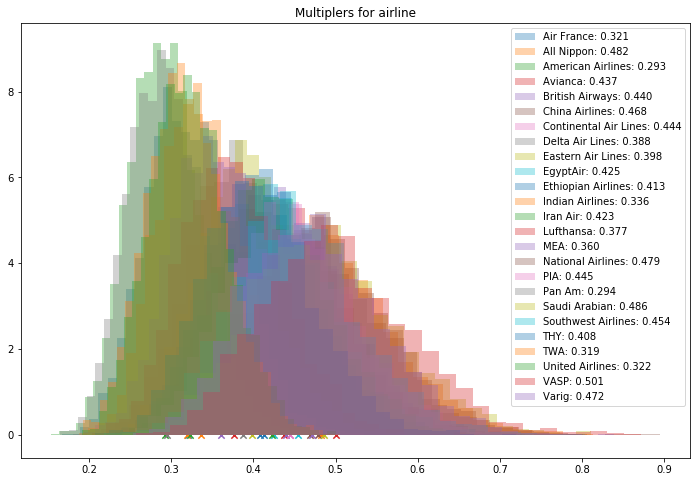

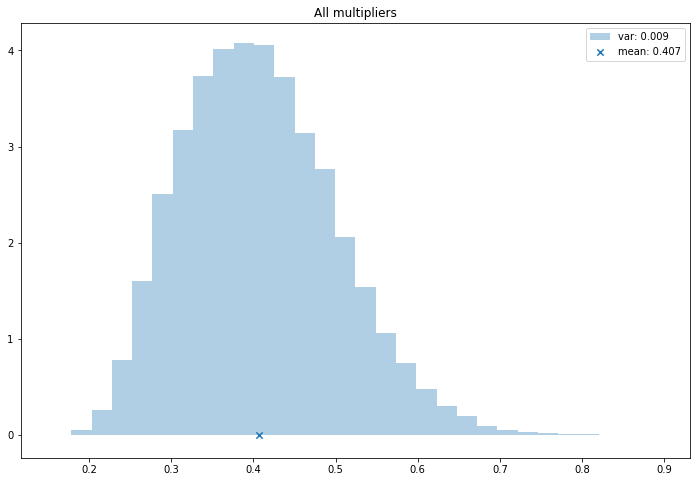

95% CI for all airline multipliers is: (0.2506762698556821, 0.6066694681016717)


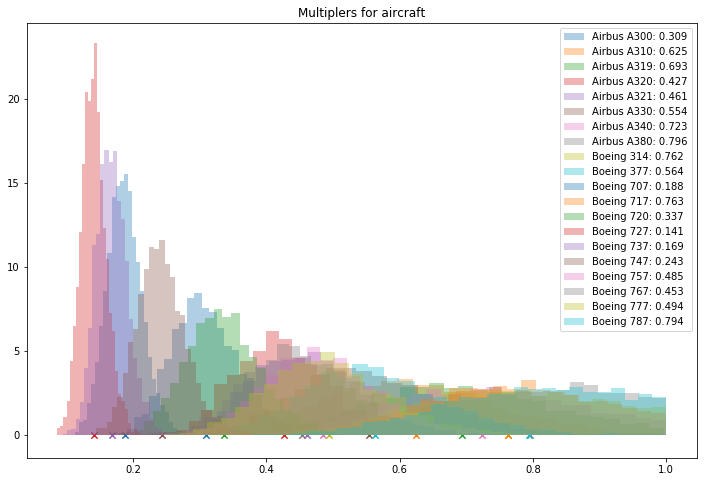

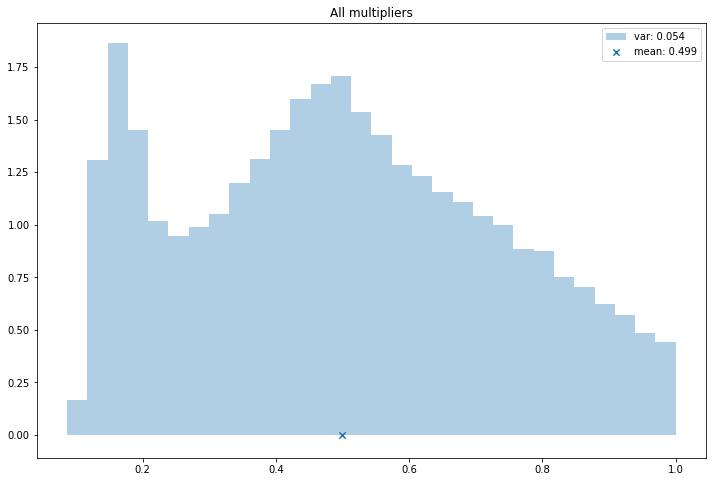

95% CI for all aircraft multipliers is: (0.13628413627358452, 0.94568858761669)


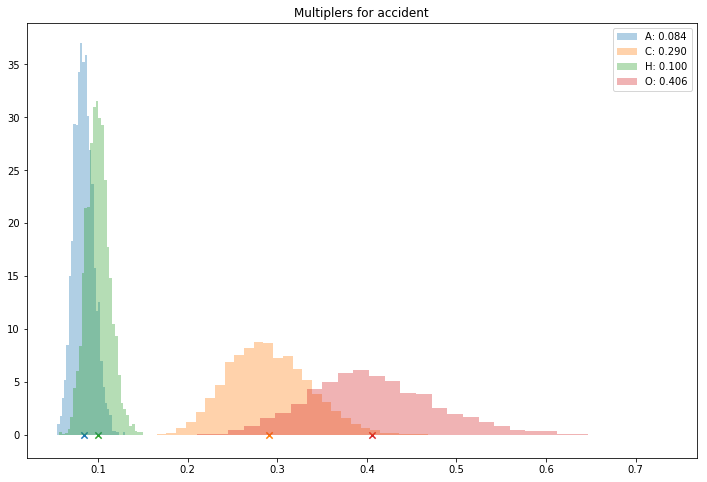

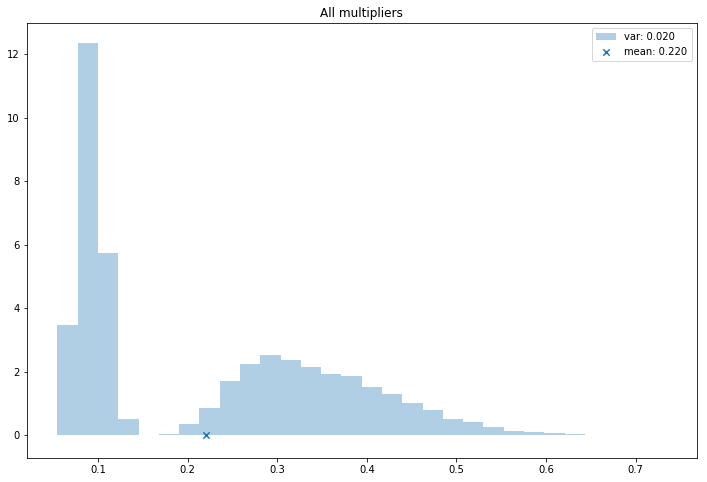

95% CI for all accident multipliers is: (0.07003385721051038, 0.5010206682506392)


In [14]:
plot_posterior(results, name, 'airline')
plot_posterior(results, name, 'aircraft')
plot_posterior(results, name, 'accident')

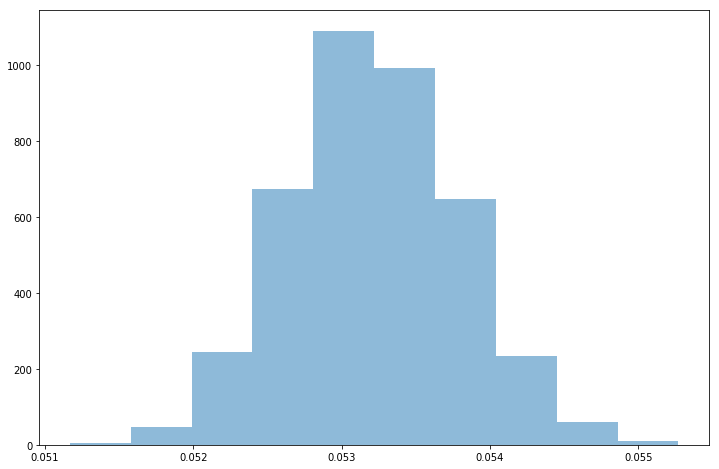

In [16]:
plt.figure(figsize=(12,8))
plt.hist(results['p'], alpha=0.5)
plt.show()

#####################################################################################################################

In [18]:
stan_model_risk_hull = """

data {
//Number of airline
    int<lower=1> L;
//Number of aircraft
    int<lower=1> C;
//Number of accident type
    int<lower=1> T;
//Number of datapoint
    int<lower=1> N;
    
//A vector of 0/1 in each entry expressing which airline, aircraft and accident type the datapoint is
    vector<lower=0>[L] airline[N];
    vector<lower=0>[C] aircraft[N];
    vector<lower=0>[T] accident[N];

// Binary indicator of whether it's a hull loss or not
    int<lower=0> hull[N];
}


parameters {

//Scaling factor for the airline
    row_vector<lower=0, upper=1>[L] m_al;
//Scaling factor for the aircraft
    row_vector<lower=0, upper=1>[C] m_ac;
//Scaling factor for the accident type
    row_vector<lower=0, upper=1>[T] m_a;

//Mortality rate
    real<lower=0, upper=1> p;
}

model {

    for (l in 1:L){
        m_al[l] ~ lognormal(0,0.25);
    }
    
    for (c in 1:C){
        m_ac[c] ~ lognormal(0,0.25);
    }
    
    for (t in 1:T){
        m_a[t] ~ lognormal(0,0.25);
    }
    
    for(i in 1:N) {
        p ~ beta(((m_al*airline[i])+(m_ac*aircraft[i])+(m_a*accident[i])), 1);
        hull[i] ~ bernoulli(p); 
    }
}

"""
model_risk_hull = pystan.StanModel(model_code=stan_model_risk_hull)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0c5a97cce61501490c5f12b232b849cd NOW.
/Users/ash/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/kg/zv3bhpmx19s5f8hsk7h4_wnc0000gn/T/tmpd9nenglk/stanfit4anon_model_0c5a97cce61501490c5f12b232b849cd_5064326410277555106.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [28]:
stan_data, name = produce_stan_data(risk_data)
results = model_risk_hull.sampling(data=stan_data, n_jobs=1)
results

Inference for Stan model: anon_model_0c5a97cce61501490c5f12b232b849cd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
m_al[1]    0.87  1.1e-3    0.1   0.64   0.82   0.89   0.95   0.99   8098    1.0
m_al[2]    0.85  1.2e-3   0.11    0.6   0.78   0.86   0.93   0.99   7968    1.0
m_al[3]    0.88  1.1e-3   0.09   0.65   0.83    0.9   0.96    1.0   6932    1.0
m_al[4]    0.85  1.2e-3   0.11    0.6   0.78   0.87   0.94   0.99   7510    1.0
m_al[5]    0.85  1.3e-3   0.11    0.6   0.79   0.87   0.94   0.99   6512    1.0
m_al[6]    0.85  1.4e-3   0.11    0.6   0.78   0.87   0.94    1.0   6396    1.0
m_al[7]    0.85  1.3e-3   0.11    0.6   0.79   0.87   0.94   0.99   7039    1.0
m_al[8]    0.86  1.3e-3    0.1   0.62   0.79   0.88   0.94   0.99   6360    1.0
m_al[9]    0.86  1.3e-3   0.11   0.61   0.79   0.88   0.94   0.99   6248    1.0
m_al[10]   

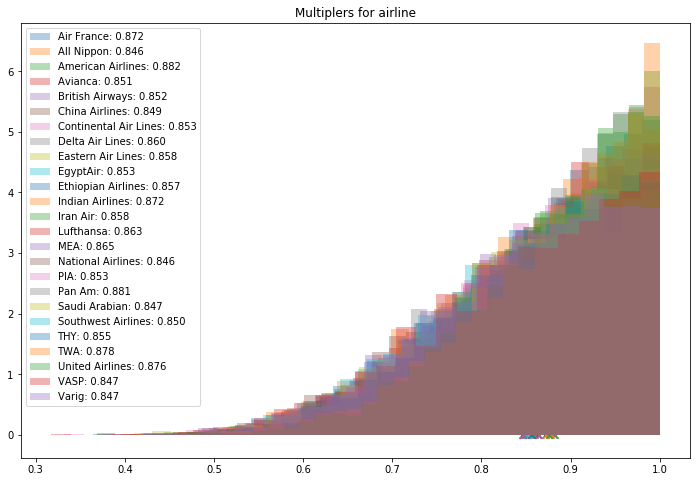

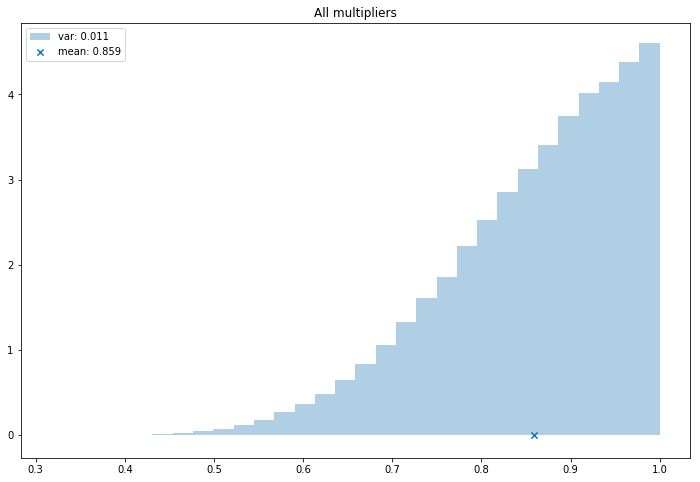

95% CI for all airline multipliers is: (0.6139308268394734, 0.9945979105863385)


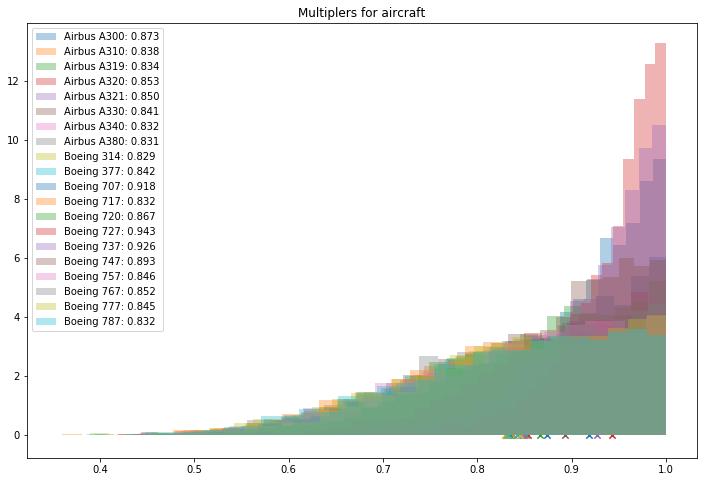

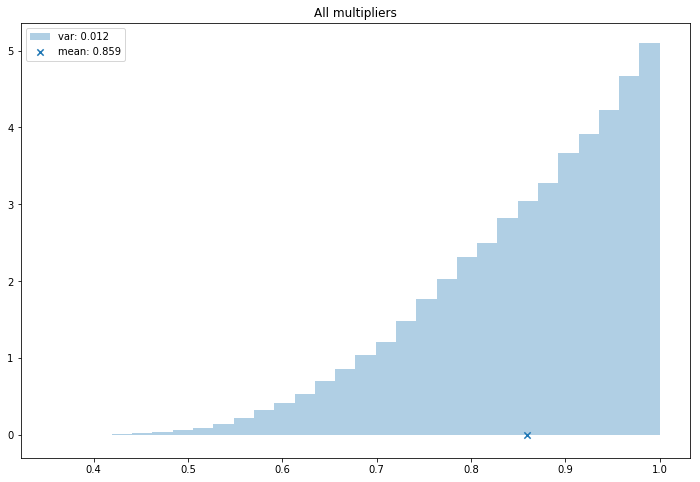

95% CI for all aircraft multipliers is: (0.6045745105230524, 0.9952848933434908)


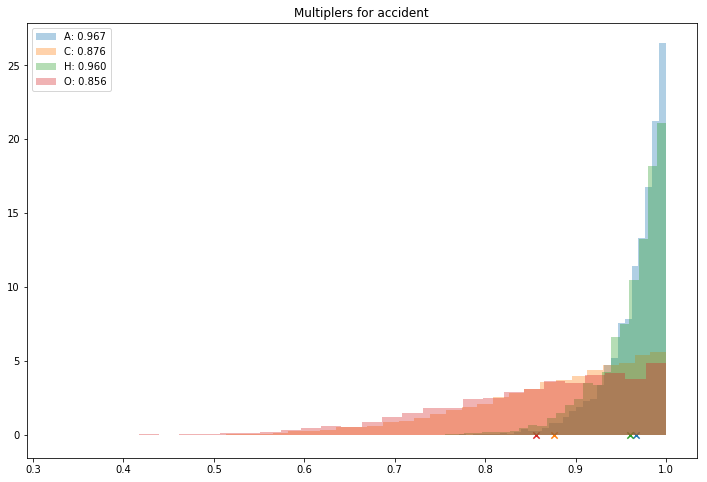

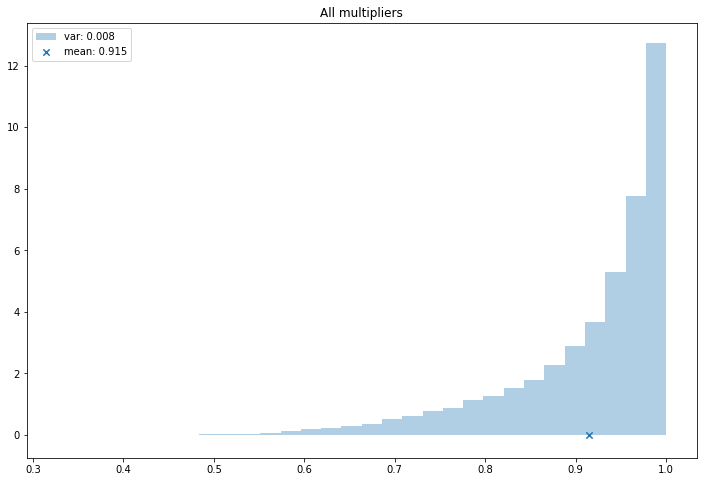

95% CI for all accident multipliers is: (0.6712876659859196, 0.9984607733093663)


In [29]:
plot_posterior(results, name, 'airline')
plot_posterior(results, name, 'aircraft')
plot_posterior(results, name, 'accident')

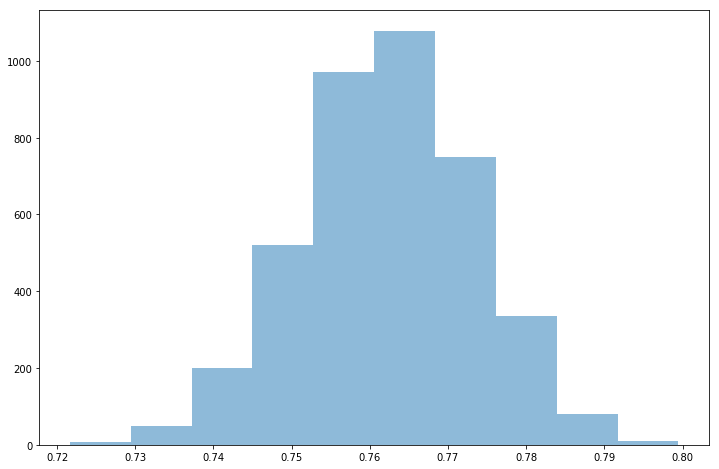

In [30]:
plt.figure(figsize=(12,8))
plt.hist(results['p'], alpha=0.5)
plt.show()